In [40]:
import bisect
import time
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

## Preparación del dataset

### Variables agregadas

time_diff_seconds: Tiempo de diferencia entre transacciones consecutivas
- Indica que tan seguido gasta el cliente entre transacciones

hour_window: Ventana de tiempo por tiempo Unix
trans_per_hour: Cantidad de transaciones por hora que se hace con la tarjeta
- Indica cuantas transacciones son hechas por hora por cliente 

hour_trans_ratio: Ratio de transacciones por hora de cada tarjeta
- Nos indica la continuidad de las transacciones por hora por cliente

unusual_distance: Calculamos si existe una inusual distancia entre el cliente y el vendedor
- Nos ayuda a saber que tal lejos esta la transacción hecha por el usuario

distance_diff: Diferencia entre la distancia entre el cliente y el vendedor
velocity_km_h: Velocidad requerida entre transacciones consecutivas
- Indica que tan rápido se tuve que mover el cliente para realizar la transacción

mean_dist_merchant: Distancia media entre el cliente y el vendedor
std_dist_merchant: Desviación estándar entre el cliente y el vendedor
dist_z_score: Indica a cuantás desviaciones estándar de distancia se encuentra la transacciones, comparado con el resto.
- Indica si existe alguna distancia inusual entre el cliente y el vendedor

amt_month_ratio: Ratio de la cantidad mensual que se gasta el cliente en transacciones
amt_year_ratio: Radio de la cantidad anual que se gasta el cliente en transacciones
- Identifica si existen cantidades que son más grandes o pequeñas de lo usual acostumbrado por el cliente

mean_amt_category: Cantidad media que se gasta el cliente por categoría
std_amt_category: Desviación estandar de la cantidad que se gasta el cliente por categoría
amt_z_score: Indica a cuantas desviaciones estandar de cantidad se encuentra la transacción, comparado con el resto.
- Identifica si existen cantidad más altas o más bajas de las que compra el cliente por categoría

high_amt_first_time: Primera transaccion de alto monto
- Identifica si el usuario hizo por primera vez una compra muy por encima del monto usual a un vendedor

mean_times_day_merchant: Media de la cantidad de veces por día que el cliente compra al vendedor
std_times_day_merchant: Desviación estándar de la cantidad de veces que el cliente compra al vendedor
times_day_z_score: Indica a cuantas desviaciones estándar de compras hechas por día al vendedor se encuentra la transacción comparado con el resto.
- Nos ayuda a identificar si el usuario realizo transacciones más frecuentes de lo normal a un vendedor

unique_cards_per_hour: Cantidad de tarjetas de créditos diferentes utilizadas en cada vendedor
- Nos ayuda a identificar si un vendedor tiene una gran cantidad de tarjetas utilizadas en su comercio, inusualmente grande a lo normal.

amt_variance_hour: Cantidad gastada en cada ventana de tiempo.
- Nos ayuda a identificar si sucede una cantidad inusual de compras dentro de una ventana de tiempo en específico.

### Adaptar el dataset

In [41]:
# Cargamos modelo
df = pd.read_csv('../data/data_engineered.csv')

In [42]:
# Eliminamos columnas innecesarias
df = df.drop(columns=['first', 'last', 'city_pop', 'street', 'job', 'dob', 'trans_num', 'hour_window', 'unix_time', 'is_fraud'])

In [43]:
df[df['is_coordinated_attack'] == 1]

,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,...,mean_amt_category,std_amt_category,amt_z_score,high_amt_first_time,mean_times_day_merchant,std_times_day_merchant,times_day_z_score,unique_cards_per_hour,amt_variance_hour,is_coordinated_attack
119,60416207185,"fraud_windler, goodwin and kovacek",home,261.79,f,fort washakie,wy,82514,43.0048,-108.8964,...,58.188180,48.504225,4.197610,1,1.773311,0.946483,0.239507,1,0.0,1
2458,60422928733,fraud_schmidt and sons,shopping_net,897.82,m,north augusta,sc,29860,33.6028,-81.9748,...,86.941974,244.277766,3.319492,1,1.626191,0.883611,-0.708673,1,0.0,1
4462,60423098130,fraud_beer-jast,kids_pets,5.21,m,amorita,ok,73719,36.9412,-98.2458,...,57.527851,48.729840,-1.073631,0,1.685575,0.870300,-0.787746,1,0.0,1
5228,60427851591,"fraud_moore, dibbert and koepp",misc_net,782.40,m,burns flat,ok,73624,35.3492,-99.1880,...,80.181370,165.896953,4.232860,1,1.415135,0.711178,-0.583729,1,0.0,1
5231,60427851591,"fraud_reichert, rowe and mraz",shopping_net,1053.81,m,burns flat,ok,73624,35.3492,-99.1880,...,86.941974,244.277766,3.958068,1,1.608953,0.828718,0.471870,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846263,4973530368125489546,"fraud_bradtke, torp and bahringer",personal_care,15.87,f,winslow,ar,72959,35.8312,-94.1187,...,48.047896,49.284712,-0.652898,0,1.557377,0.822805,-0.677411,1,0.0,1
1846266,4973530368125489546,"fraud_altenwerth, cartwright and koss",shopping_net,1018.47,f,winslow,ar,72959,35.8312,-94.1187,...,86.941974,244.277766,3.813397,1,1.668603,0.928535,-0.720062,1,0.0,1
1847732,4980323467523543940,fraud_bashirian group,shopping_net,837.31,m,north haverhill,nh,3774,44.0978,-72.0191,...,86.941974,244.277766,3.071782,1,1.629412,0.841295,-0.748146,1,0.0,1
1847735,4980323467523543940,fraud_flatley-durgan,misc_net,888.03,m,north haverhill,nh,3774,44.0978,-72.0191,...,80.181370,165.896953,4.869581,1,1.432218,0.736070,-0.587197,1,0.0,1


### Separación de la data 

Dividimos en train y test el dataset

In [44]:
train_mask = (df['trans_month'] == 12) & (df['year'] == 2020)
df_train = df[~train_mask]

df_test = df[((df['trans_month'] == 12) & (df['year'] == 2020))]

Dividimos los train y test con los datos y las respuestas

In [45]:
X_train = df_train.drop(columns=['is_coordinated_attack'])
y_train = df_train['is_coordinated_attack']

X_test = df_test.drop(columns=['is_coordinated_attack'])
y_test = df_test['is_coordinated_attack']

Identificamos las variables categoricas

In [46]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

In [47]:
categorical_cols

Index(['merchant', 'category', 'gender', 'city', 'state'], dtype='object')

In [48]:
numerical_cols

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'merch_lat', 'merch_long',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'dist_between_client_and_merch',
       'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant',
       'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month',
       'times_shopped_at_merchant_day', 'time_diff_seconds', 'trans_per_hour',
       'hour_trans_ratio', 'unusual_distance', 'distance_diff',
       'velocity_km_h', 'mean_dist_merchant', 'std_dist_merchant',
       'dist_z_score', 'amt_month_ratio', 'amt_year_ratio',
       'mean_amt_category', 'std_amt_category', 'amt_z_score',
       'high_amt_first_time', 'mean_times_day_merchant',
       'std_times_day_merchant', 'times_day_z_score', 'unique_cards_per_hour',
       'amt_variance_hour'],
      dtype='object')

Copiamos los datasets de datos

In [49]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

Procesamos las variables categoricas

In [50]:
for col in categorical_cols:
    le = LabelEncoder()
    X_train_processed[col] = le.fit_transform(X_train[col].astype(str))

    X_test_processed[col] = X_test[col].astype(str).map(lambda s: '<unknown>' if s not in le.classes_ else s)
    
    if '<unknown>' not in le.classes_:
        if X_test_processed[col].eq('<unknown>').any():
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, '<unknown>')
            le.classes_ = np.array(le_classes)
        
    X_test_processed[col] = le.transform(X_test_processed[col])

## Primer Intento

Definimos los parámetros para nuestro modelo

In [51]:
lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    objective='binary',
    random_state=123,
    n_jobs=2,
    is_unbalance=True
)

Entrenamos el modelo que definimos con la data de entrenamiento

In [52]:
lgbm_classifier.fit(X_train_processed, y_train)

[LightGBM] [Info] Number of positive: 1091, number of negative: 1711765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7132
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000637 -> initscore=-7.358186
[LightGBM] [Info] Start training from score -7.358186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

LGBMClassifier(is_unbalance=True, n_jobs=2, objective='binary',
               random_state=123)

Obtenemos las predicciones del modelo entrenado utilizando los datos de prueba

In [53]:
y_pred_lgbm = lgbm_classifier.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test_processed)[:, 1]

In [54]:
print("\nClassification Report:")
report_basic_lgbm = classification_report(y_test, y_pred_lgbm, target_names=['Not Coordinated Attack', 'Coordinated Attack'], output_dict=True)
print(report_basic_lgbm)

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgbm))

print("\nF1 Score:")
print(f1_score(y_test, y_pred_lgbm, average='weighted'))



Classification Report:
{'Not Coordinated Attack': {'precision': 1.0, 'recall': 0.24511546566132938, 'f1-score': 0.3937232689197046, 'support': 139522.0}, 'Coordinated Attack': {'precision': 0.00015189056284946697, 'recall': 1.0, 'f1-score': 0.0003037349912201604, 'support': 16.0}, 'accuracy': 0.245202023821468, 'macro avg': {'precision': 0.5000759452814247, 'recall': 0.6225577328306647, 'f1-score': 0.19701350195546238, 'support': 139538.0}, 'weighted avg': {'precision': 0.9998853533105606, 'recall': 0.245202023821468, 'f1-score': 0.3936781578206287, 'support': 139538.0}}

ROC AUC Score:
0.6225577328306646

F1 Score:
0.3936781578206287


In [55]:
print("\nFeature Importances (LightGBM):")
importances = lgbm_classifier.feature_importances_
feature_names = X_train_processed.columns
sorted_indices = np.argsort(importances)[::-1]

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature Importances (LightGBM):
time_diff_seconds: 42
amt_z_score: 31
velocity_km_h: 26
amt: 26
amt_year_ratio: 20
distance_diff: 20
hour: 15
mean_times_day_merchant: 13
amt_year: 12
amt_month_shopping_net_spend: 12
times_shopped_at_merchant: 8
dist_between_client_and_merch: 7
dist_z_score: 7
mean_amt_category: 7
first_time_at_merchant: 6
amt_month_ratio: 6
trans_month: 6
high_amt_first_time: 6
mean_dist_merchant: 5
trans_per_hour: 5
year: 5
times_shopped_at_merchant_year: 5
unique_cards_per_hour: 4
amt_variance_hour: 4
hour_trans_ratio: 4
times_day_z_score: 4
std_times_day_merchant: 4
zip: 3
times_shopped_at_merchant_day: 3
cc_num: 2
category: 2
std_dist_merchant: 2
std_amt_category: 2
amt_month: 2
merchant: 1
state: 1
merch_lat: 1
merch_long: 1
count_month_shopping_net: 1
unusual_distance: 1
lat: 0
long: 0
city: 0
gender: 0
trans_day: 0
times_shopped_at_merchant_month: 0


Imprimimos las features más importantes dentro de las predicciones del modelo

## Métricas Personalizadas

Crear datasets de LightGBM

In [56]:
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)

### Métrica usando cantidad de tarjetas y varianza en la cantidad por hora

In [ ]:
def custom_unique_card_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad al detectar si se realiza un ataque coordinado, 
    identificando si se usaron muchas tarjetas diferentes en un periodo corto de tiempo.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
         # Acceder a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        unique_cards = data_to_use['unique_cards_per_hour'].values
        amt_variance = data_to_use['amt_variance_hour'].values
        
        # Identificar posibles ataques coordinados, al identificar si se usaron 
        # muchas tarjetas únicas en un periodo muy corto de tiempo.
        potential_coordinated_attacks = (unique_cards > unique_cards.mean() + 2*unique_cards.std()) | \
                                       (amt_variance < amt_variance.mean() - 2*amt_variance.std())
        
        # Calcular métricas específicas para ataques coordinados
        true_pos_coord = np.sum((labels == 1) & (preds_binary == 1) & potential_coordinated_attacks)
        false_neg_coord = np.sum((labels == 1) & (preds_binary == 0) & potential_coordinated_attacks)
        
        # Penalizar fuertemente los falsos negativos en ataques coordinados
        if true_pos_coord + false_neg_coord > 0:
            coordinated_recall = true_pos_coord / (true_pos_coord + false_neg_coord)
        else:
            coordinated_recall = 1.0  # No hay casos de ataques coordinados
            
        # Métrica general (ponderamos más los errores en ataques coordinados)
        error = np.mean(preds_binary != labels)
        weighted_error = error * 0.3 + (1 - coordinated_recall) * 0.7
        
        return 'unique_card_metric', weighted_error, False
        
    except (ValueError, IndexError):
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives
            
        return 'unique_card_metric', ratio, False  # False porque una tasa menor es mejor

In [58]:
# Configurar parámetros
params_unique_card = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'precision', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.01, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.8, # Definimos la regularización L1
    'lambda_l2': 0.5, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'dart', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_unique_card = lgb.train(
    params_unique_card,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_unique_card_metric # Colocamos nuestra función de evaluación personalizada
)

[LightGBM] [Info] Number of positive: 1091, number of negative: 1711765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000637 -> initscore=-7.358186
[LightGBM] [Info] Start training from score -7.358186


In [59]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_unique_card = model_unique_card.predict(X_test_processed)
# Convertir a clases
y_pred_binary_unique_card = np.where(y_pred_unique_card > 0.5, 1, 0)

# Calcular las métricas
accuracy_unique_card = accuracy_score(y_test, y_pred_binary_unique_card)
auc_unique_card = roc_auc_score(y_test, y_pred_unique_card)

print("\nClassification Report:")
report_unique_card = classification_report(y_test, y_pred_binary_unique_card, target_names=['Not Coordinated Attack', 'Coordinated Attack'], output_dict=True)
print(report_unique_card)

print(f"Accuracy: {accuracy_unique_card:.4f}")
print(f"ROC AUC Score: {auc_unique_card:.4f}")


Classification Report:
{'Not Coordinated Attack': {'precision': 0.9999928251121076, 'recall': 0.998939235389401, 'f1-score': 0.9994657525896657, 'support': 139522.0}, 'Coordinated Attack': {'precision': 0.09202453987730061, 'recall': 0.9375, 'f1-score': 0.16759776536312848, 'support': 16.0}, 'accuracy': 0.9989321905144118, 'macro avg': {'precision': 0.5460086824947041, 'recall': 0.9682196176947004, 'f1-score': 0.5835317589763971, 'support': 139538.0}, 'weighted avg': {'precision': 0.9998887137405547, 'recall': 0.9989321905144118, 'f1-score': 0.9993703671907377, 'support': 139538.0}}
Accuracy: 0.9989
ROC AUC Score: 0.9998


### Métrica usando la frecuencia de compra a un vendedor

In [60]:
def custom_merchant_frequency_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo
    en la detección de ataques coordinados basados en patrones inusuales de frecuencia
    de compra entre un usuario y un comerciante.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
        # Acceder a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        # Características importantes para analizar frecuencia usuario-vendedor
        first_time = data_to_use['first_time_at_merchant'].values
        high_amt_first = data_to_use['high_amt_first_time'].values
        times_day_z = data_to_use['times_day_z_score'].values
        
        # Identificar transacciones potencialmente sospechosas por frecuencia
        suspicious_frequency = (first_time == 1) | (high_amt_first == 1) | (times_day_z > 2.0)
        
        # Calcular métricas específicas para patrón de frecuencia inusual
        true_pos_freq = np.sum((labels == 1) & (preds_binary == 1) & suspicious_frequency)
        false_neg_freq = np.sum((labels == 1) & (preds_binary == 0) & suspicious_frequency)
        
        # Calcular el recall en transacciones con frecuencia sospechosa
        if true_pos_freq + false_neg_freq > 0:
            frequency_recall = true_pos_freq / (true_pos_freq + false_neg_freq)
        else:
            frequency_recall = 1.0  # No hay casos sospechosos
        
        # Calculamos las métricas generales
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_positives = np.sum((labels == 0) & (preds_binary == 1))
        
        # Calcular precisión para ataques coordinados en general
        if true_positives + false_positives > 0:
            precision = true_positives / (true_positives + false_positives)
        else:
            precision = 0.0
            
        # Métrica combinada: Balance entre precisión general y recall en casos sospechosos
        # Ponderamos más el recall en casos sospechosos por frecuencia (0.7 vs 0.3)
        weighted_score = 0.3 * precision + 0.7 * frequency_recall
        
        # Invertimos el score para que un valor menor sea mejor (para optimización)
        inverted_score = 1.0 - weighted_score
        
        return 'merchant_frequency_metric', inverted_score, False  # False porque un valor menor es mejor
        
    except (ValueError, IndexError):
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives

        return 'merchant_frequency_metric', ratio, False  # Invertimos F1 para que menor sea mejor

In [61]:
# Configurar parámetros
params_merchant_frequency = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'precision', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 42, # Definimos el número de hojas de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.8, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.6, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'gbdt', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_merchant_frequency = lgb.train(
    params_merchant_frequency,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_merchant_frequency_metric
)

[LightGBM] [Info] Number of positive: 1091, number of negative: 1711765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000637 -> initscore=-7.358186
[LightGBM] [Info] Start training from score -7.358186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [62]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_merchant_frequency = model_merchant_frequency.predict(X_test_processed)
# Convertir a clases
y_pred_binary_merchant_frequency = np.where(y_pred_merchant_frequency > 0.5, 1, 0)

# Calcular las métricas
accuracy_merchant_frequency = accuracy_score(y_test, y_pred_binary_merchant_frequency)
auc_merchant_frequency = roc_auc_score(y_test, y_pred_merchant_frequency)

print("\nClassification Report:")
report_merchant_frequency = classification_report(y_test, y_pred_binary_merchant_frequency, target_names=['Not Coordinated Attack', 'Coordinated Attack'], output_dict=True)
print(report_merchant_frequency)

print(f"Accuracy: {accuracy_merchant_frequency:.4f}")
print(f"ROC AUC Score: {auc_merchant_frequency:.4f}")


Classification Report:
{'Not Coordinated Attack': {'precision': 0.9999928174851143, 'recall': 0.9978784707788019, 'f1-score': 0.9989345253256514, 'support': 139522.0}, 'Coordinated Attack': {'precision': 0.04823151125401929, 'recall': 0.9375, 'f1-score': 0.09174311926605505, 'support': 16.0}, 'accuracy': 0.9978715475354384, 'macro avg': {'precision': 0.5241121643695668, 'recall': 0.9676892353894009, 'f1-score': 0.5453388222958533, 'support': 139538.0}, 'weighted avg': {'precision': 0.999883684625967, 'recall': 0.9978715475354384, 'f1-score': 0.9988305030342544, 'support': 139538.0}}
Accuracy: 0.9979
ROC AUC Score: 0.9468


### Métrica identificando anomalías en distancias

In [63]:
def custom_distance_anomaly_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo
    en la detección de ataques coordinados basados en anomalías de distancia y velocidad.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
        # Accedemos a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        # Características relacionadas con la distancia
        unusual_distance = data_to_use['unusual_distance'].values
        velocity_km_h = data_to_use['velocity_km_h'].values
        dist_z_score = data_to_use['dist_z_score'].values
        
        # Definimos umbrales para identificar anomalías
        velocity_threshold = 300  # km/h (velocidad imposible entre transacciones)
        z_score_threshold = 2.5   # Más de 2.5 desviaciones estándar es muy inusual
        
        # Identificamos transacciones con anomalías de distancia, viendo si la cumple con algunos de los siguientes
        distance_anomalies = (unusual_distance == 1) | \
                             (velocity_km_h > velocity_threshold) | \
                             (np.abs(dist_z_score) > z_score_threshold)
        
        # Calculamos métricas específicas para anomalías de distancia
        true_pos_dist = np.sum((labels == 1) & (preds_binary == 1) & distance_anomalies)
        false_neg_dist = np.sum((labels == 1) & (preds_binary == 0) & distance_anomalies)
        false_pos_dist = np.sum((labels == 0) & (preds_binary == 1) & distance_anomalies)
        
        # Calculamos métricas generales
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_positives = np.sum((labels == 0) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        # Calculamos recall específico para anomalías de distancia
        if true_pos_dist + false_neg_dist > 0:
            distance_recall = true_pos_dist / (true_pos_dist + false_neg_dist)
        else:
            distance_recall = 1.0  # No hay anomalías de distancia con ataques coordinados
        
        # Calculamos precisión específica para anomalías de distancia
        if true_pos_dist + false_pos_dist > 0:
            distance_precision = true_pos_dist / (true_pos_dist + false_pos_dist)
        else:
            distance_precision = 1.0  # No hay predicciones positivas para anomalías
        
        # Calculamos recall general
        if true_positives + false_negatives > 0:
            general_recall = true_positives / (true_positives + false_negatives)
        else:
            general_recall = 0.0
            
        # Calculamos precisión general
        if true_positives + false_positives > 0:
            general_precision = true_positives / (true_positives + false_positives)
        else:
            general_precision = 0.0
        
        # Calculamos F1-score para anomalías de distancia
        if distance_precision + distance_recall > 0:
            distance_f1 = 2 * (distance_precision * distance_recall) / (distance_precision + distance_recall)
        else:
            distance_f1 = 0.0
        
        # Métrica combinada: Balance entre métricas generales y específicas de distancia
        # Damos más peso a la detección de anomalías de distancia
        weighted_score = 0.3 * general_precision + 0.2 * general_recall + 0.5 * distance_f1
        
        # Invertimos para que un valor menor sea mejor
        inverted_score = 1.0 - weighted_score
        
        return 'distance_anomaly_metric', inverted_score, False  # False porque un valor menor es mejor
    
    except (ValueError, IndexError, KeyError) as e:
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives
        
        return 'distance_anomaly_metric', ratio, False

In [64]:
# Configurar parámetros
params_distance_anomaly = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'binary_logloss', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.5, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'gbdt', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_distance_anomaly = lgb.train(
    params_distance_anomaly,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_distance_anomaly_metric,
)

[LightGBM] [Info] Number of positive: 1091, number of negative: 1711765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000637 -> initscore=-7.358186
[LightGBM] [Info] Start training from score -7.358186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [65]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_distance_anomaly = model_distance_anomaly.predict(X_test_processed)
# Convertir a clases
y_pred_binary_distance_anomaly = np.where(y_pred_distance_anomaly > 0.5, 1, 0)

# Calcular las métricas
accuracy_distance_anomaly = accuracy_score(y_test, y_pred_binary_distance_anomaly)
auc_distance_anomaly = roc_auc_score(y_test, y_pred_distance_anomaly)

print("\nClassification Report:")
report_distance_anomaly = classification_report(y_test, y_pred_binary_distance_anomaly, target_names=['Not Coordinated Attack', 'Coordinated Attack'], output_dict=True)
print(report_distance_anomaly)

print(f"Accuracy: {accuracy_distance_anomaly:.4f}")
print(f"AUC: {auc_distance_anomaly:.4f}")


Classification Report:
{'Not Coordinated Attack': {'precision': 0.999978376664096, 'recall': 0.9943664798383051, 'f1-score': 0.9971645325791254, 'support': 139522.0}, 'Coordinated Attack': {'precision': 0.016270337922403004, 'recall': 0.8125, 'f1-score': 0.03190184049079755, 'support': 16.0}, 'accuracy': 0.9943456262810131, 'macro avg': {'precision': 0.5081243572932495, 'recall': 0.9034332399191525, 'f1-score': 0.5145331865349615, 'support': 139538.0}, 'weighted avg': {'precision': 0.999865580661431, 'recall': 0.9943456262810131, 'f1-score': 0.9970538515956414, 'support': 139538.0}}
Accuracy: 0.9943
AUC: 0.9183


## Comparación entre los modelos

### Confusion Matrix

Colocamos todas las matrices de confusión de los 4 modelos que creamos para comparación de la calidad de predicción hecha por cada una.

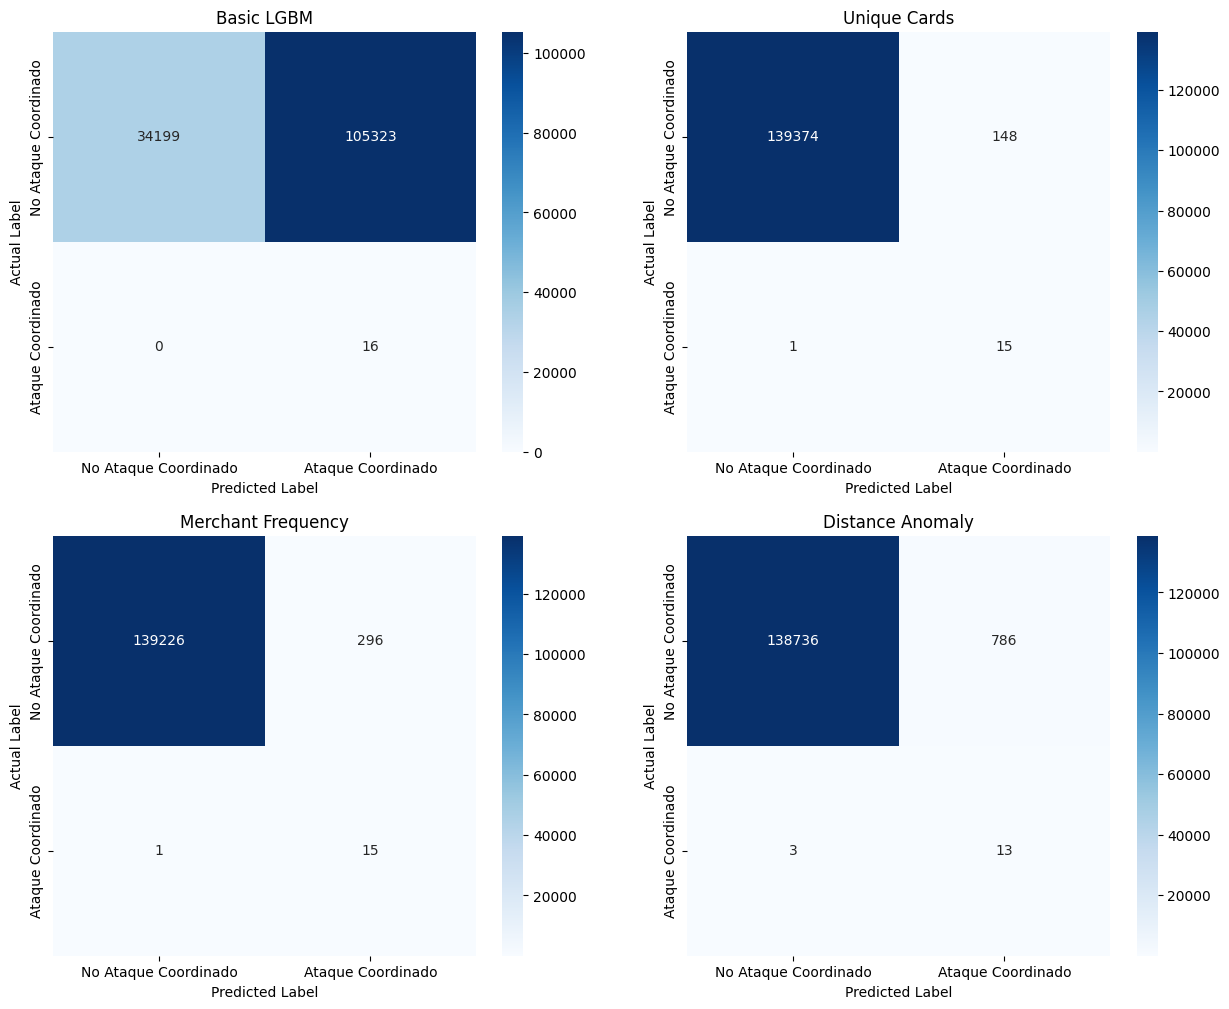

<Figure size 800x600 with 0 Axes>

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

cm_basic_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_basic_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], yticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], ax=axes[0, 0])
axes[0,0].set_title('Basic LGBM')
axes[0,0].set_ylabel('Actual Label')
axes[0,0].set_xlabel('Predicted Label')

cm_unique_card = confusion_matrix(y_test, y_pred_binary_unique_card)
sns.heatmap(cm_unique_card, annot=True, fmt='d', cmap='Blues', xticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], 
            yticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], ax=axes[0,1])
axes[0,1].set_title('Unique Cards')
axes[0,1].set_ylabel('Actual Label')
axes[0,1].set_xlabel('Predicted Label')

cm_merchant_frequency = confusion_matrix(y_test, y_pred_binary_merchant_frequency)
sns.heatmap(cm_merchant_frequency, annot=True, fmt='d', cmap='Blues', xticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], 
            yticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], ax=axes[1,0])
axes[1,0].set_title('Merchant Frequency')
axes[1,0].set_ylabel('Actual Label')
axes[1,0].set_xlabel('Predicted Label')

cm_distance_anomaly = confusion_matrix(y_test, y_pred_binary_distance_anomaly)
sns.heatmap(cm_distance_anomaly, annot=True, fmt='d', cmap='Blues', xticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], 
            yticklabels=['No Ataque Coordinado', 'Ataque Coordinado'], ax=axes[1,1])
axes[1,1].set_title('Distance Anomaly')
axes[1,1].set_ylabel('Actual Label')
axes[1,1].set_xlabel('Predicted Label')

plt.suptitle('Confusion Matrices Comparison', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Se puede observar que al comparar las matrices de confusión de todos los modelos, tenemos que el modelo `Basic LGBM` pudo clasificar todas las transacciones parte de ataques coordinados, sin embargo, podemos ver que clasificó una cantidad muy grande de falsos positivos (alrededor del 75% de las transacciones que no son parte de ataques coordinados). Tenemos que los otros dos mejores fueron el `Unique Cards` y el `Merchant Frequency`, teniendo una caída considerable de falsos positivos comparado con el `Basic LGBM`. Siendo el mejor de los dos el `Unique Cards`, con una mejora del 50% en los **falsos positivos**, mientras mantiene la misma precisión en los **ataque coordinados**. Y, por último, tenemos el modelo `Distance Anomaly`, el cual tuvo el peor rendimiento clasificando de los cuatro, teniendo una acertividad 13% menor al de los modelos más cercanos y un incremento del 62% en los falsos positivos con el modelo más cercano.

### ROC-AUC Scores

Creamos comparación de las curvas ROC-AUC de los 4 modelos que creamos

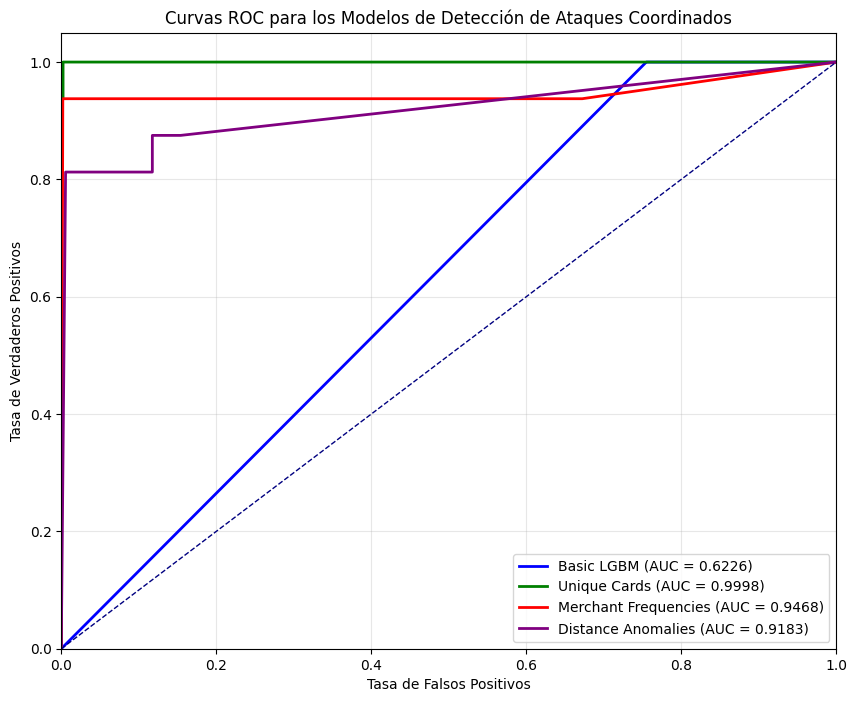

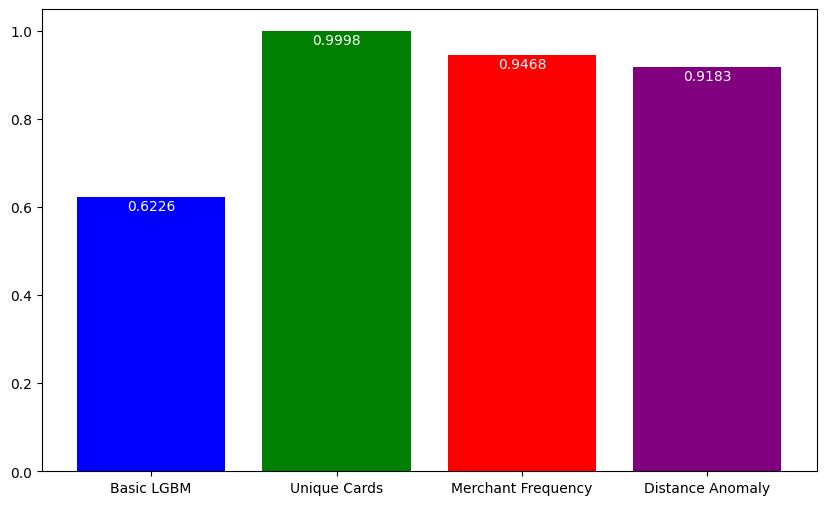

In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_unique_cards, tpr_unique_cards, _ = roc_curve(y_test, y_pred_unique_card)
fpr_merchant_frequencies, tpr_merchant_frequencies, _ = roc_curve(y_test, y_pred_merchant_frequency)
fpr_distance_anomalies, tpr_distance_anomalies, _ = roc_curve(y_test, y_pred_distance_anomaly)

roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
roc_auc_unique_cards = roc_auc_score(y_test, y_pred_unique_card)
roc_auc_merchant_frequencies = roc_auc_score(y_test, y_pred_merchant_frequency)
roc_auc_distance_anomalies = roc_auc_score(y_test, y_pred_distance_anomaly)

plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, 
         label=f'Basic LGBM (AUC = {roc_auc_lgbm:.4f})')
plt.plot(fpr_unique_cards, tpr_unique_cards, color='green', lw=2, 
         label=f'Unique Cards (AUC = {roc_auc_unique_cards:.4f})')
plt.plot(fpr_merchant_frequencies, tpr_merchant_frequencies, color='red', lw=2, 
         label=f'Merchant Frequencies (AUC = {roc_auc_merchant_frequencies:.4f})')
plt.plot(fpr_distance_anomalies, tpr_distance_anomalies, color='purple', lw=2, 
         label=f'Distance Anomalies (AUC = {roc_auc_distance_anomalies:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para los Modelos de Detección de Ataques Coordinados')

plt.legend(loc='lower right')


plt.grid(True, alpha=0.3)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()


plt.figure(figsize=(10, 6))
models = ['Basic LGBM', 'Unique Cards', 'Merchant Frequency', 'Distance Anomaly']
auc_scores = [roc_auc_lgbm, roc_auc_unique_cards, roc_auc_merchant_frequencies, roc_auc_distance_anomalies]

bars = plt.bar(models, auc_scores, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.005, 
             f'{height:.4f}', ha='center', va='top', color='white') 

Se puede observar que el modelo Basic LGBM, se encuentra muy cerca de la pendiente, lo cuál podría indicar que su método de clasificación, por más efectivo que sea, tiende a generar muchos de los resultados sin mucha certeza, resultando así en una vasta cantidad de falsos positivos. Se puede ver que los modelos con funciones de evaluación especializadas cuentan con una mejor trayectoría, mostrándonos que sus predicciones no son al azar y que si poseen cierta certeza a la hora de clasificar. Se puede ver que el mejor modelo es el de Unique Cards, con una diferencia del 5% comparado con el siguiente mejor modelo, que es el Merchant Frequency. Se puede ver que los resultados de los modelos con función de evaluación se encuentran con una diferencia de 4.07% entre cada uno de los modelos, lo cual señala que los modelos si están prediciendo con conocimientos adquiridos y no con predicciones aleatorias.


### Precision - Accuracy - F1_Score

Creamos comparación de las métricas de todos los modelos para ataques coordinados

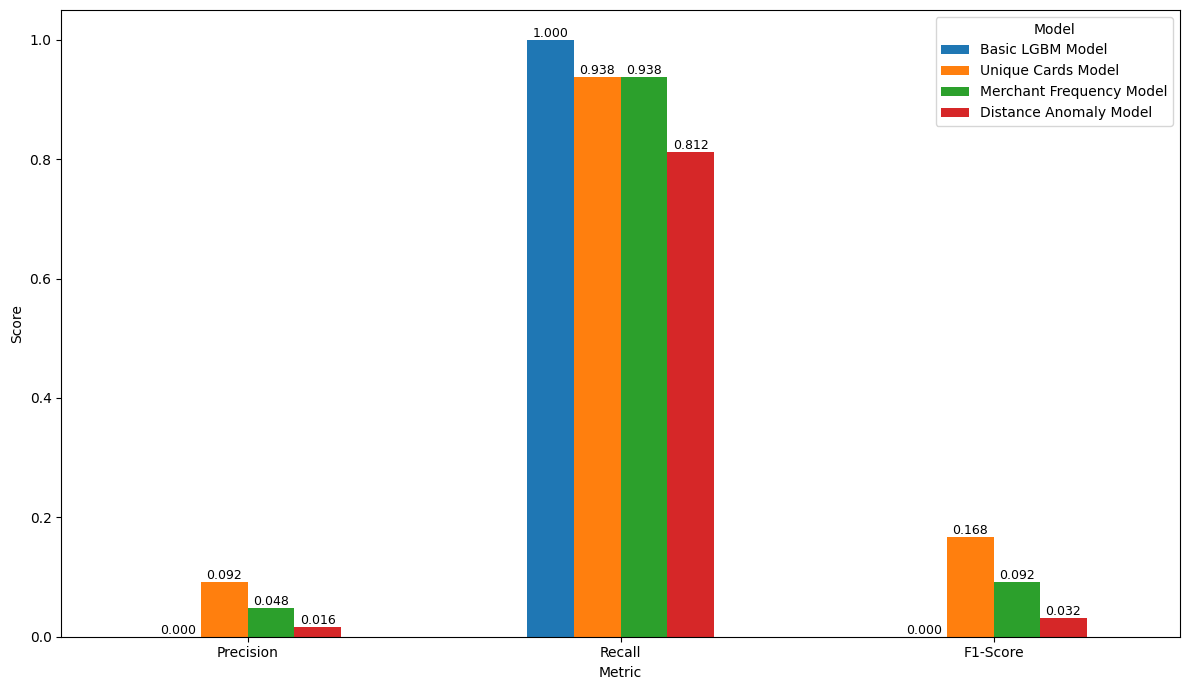

In [68]:
coordinated_attack_metric_basic_lgbm = report_basic_lgbm['Coordinated Attack']
coordinated_attack_metrics_unique_card = report_unique_card['Coordinated Attack']
coordinated_attack_metrics_merchant_frequency = report_merchant_frequency['Coordinated Attack']
coordinated_attack_metrics_distance_anomaly = report_distance_anomaly['Coordinated Attack']

comparison_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Basic LGBM Model': [
        coordinated_attack_metric_basic_lgbm['precision'],
        coordinated_attack_metric_basic_lgbm['recall'],
        coordinated_attack_metric_basic_lgbm['f1-score']
    ],
    'Unique Cards Model': [
        coordinated_attack_metrics_unique_card['precision'],
        coordinated_attack_metrics_unique_card['recall'],
        coordinated_attack_metrics_unique_card['f1-score']
    ],
    'Merchant Frequency Model': [
        coordinated_attack_metrics_merchant_frequency['precision'],
        coordinated_attack_metrics_merchant_frequency['recall'],
        coordinated_attack_metrics_merchant_frequency['f1-score']
    ],
    'Distance Anomaly Model': [
        coordinated_attack_metrics_distance_anomaly['precision'],
        coordinated_attack_metrics_distance_anomaly['recall'],
        coordinated_attack_metrics_distance_anomaly['f1-score']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

ax = df_comparison.set_index('Metric').plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')

# Agregamos los valores a cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()

### Best Model

In [69]:
print("Best model: Unique Cards")
for value, index in enumerate(df_comparison['Unique Cards Model']):
    print(f"{df_comparison['Metric'][value]}: {index}")

Best model: Unique Cards
Precision: 0.09202453987730061
Recall: 0.9375
F1-Score: 0.16759776536312848
